In [ ]:
# !pip install faiss-cpu
# !pip install onnxruntime
# !pip install pillow
# !pip install torch torchvision torchaudio

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import abc
import torch
import faiss
import logging
import numpy as np
import onnxruntime as ort
from PIL import Image
from tqdm import tqdm
from pathlib import Path
from dreamsim import dreamsim
from itertools import accumulate
from torchvision import transforms
from IPython.display import display

# 複数の OpenMP ランタイムが初期化される場合のワークアラウンド
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# --- ログの設定 ---
if True:
    logger = logging.getLogger(__name__)
    logger.setLevel(logging.INFO)
    handler = logging.StreamHandler()  # コンソール出力用ハンドラ
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    handler.setFormatter(formatter)
    logger.addHandler(handler)
else:
    logger = logging.getLogger(__name__)
    logger.setLevel(logging.CRITICAL)

class FaissManager:
    def __init__(self, dim, index_file=None, recreate=True):
        """
        Args:
            dim (int): 埋め込みベクトルの次元数
            index_file (str, optional): インデックス保存用ファイルパス
            recreate (bool): Trueの場合、既存のファイルがあっても新規作成します。
        """
        self.dim = dim
        self.index_file = index_file
        self.file_paths = []  # 各ベクトルに対応する画像ファイルパスのリスト

        if index_file is not None and os.path.exists(index_file) and not recreate:
            self.index = faiss.read_index(index_file)
            logger.info("FAISSインデックスを読み込みました。ファイル: %s", index_file)
        else:
            # 正規化済みの特徴量を使い、内積検索（IndexFlatIP）を利用します。
            self.index = faiss.IndexFlatIP(dim)
            logger.info("新しいFAISSインデックスを作成しました。")

    def add_embeddings(self, embeddings, file_paths):
        """
        埋め込みベクトルをインデックスに追加するメソッドです。
        Args:
            embeddings: 埋め込みベクトルのリストまたはNumPy配列
            file_paths: 各ベクトルに対応する画像ファイルパスのリスト
        """
        # 埋め込みをfloat32型の連続メモリのNumPy配列に変換
        embeddings = np.ascontiguousarray(np.array(embeddings, dtype=np.float32))
        if embeddings.ndim != 2 or embeddings.shape[1] != self.dim:
            raise ValueError(f"埋め込みの次元が不正です。期待値: (N, {self.dim})")
        self.index.add(embeddings)
        self.file_paths.extend(file_paths)
        logger.info("%d 件の埋め込みをインデックスに追加しました。", len(file_paths))

    def search(self, query_vector, k):
        """
        クエリベクトルに対して近傍検索を行います。
        Args:
            query_vector: 検索対象のクエリベクトル（余分な次元が含まれている場合は除去）
            k (int): 返す近傍件数
        Returns:
            distances, indices: 各クエリに対する距離とインデックスの結果
        """
        # NumPy配列に変換し、余分な次元を除去
        query_vector = np.array(query_vector, dtype=np.float32)
        query_vector = np.squeeze(query_vector)
        # 1次元の場合は (1, dim) に変換
        if query_vector.ndim == 1:
            query_vector = query_vector.reshape(1, -1)
        # 次元チェック
        if query_vector.shape[1] != self.dim:
            raise ValueError(f"次元不一致: インデックスは {self.dim} 次元ですが、クエリは {query_vector.shape[1]} 次元です。")
        distances, indices = self.index.search(query_vector, k)
        return distances, indices

    def save(self, index_file=None):
        """
        FAISSインデックスをローカルファイルに保存します。
        Args:
            index_file (str, optional): 保存するファイルパス。Noneの場合、初期化時のindex_fileを使用。
        """
        target_file = index_file if index_file is not None else self.index_file
        if target_file is None:
            raise ValueError("保存するためのファイルパスが指定されていません。")
        faiss.write_index(self.index, target_file)
        logger.info("FAISSインデックスをファイルに保存しました: %s", target_file)

# --- 画像特徴抽出基底クラス ---
class BaseFeatureExtractor(abc.ABC):
    @abc.abstractmethod
    def extract_feature(self, image_path):
        """
        画像ファイルから特徴を抽出する抽象メソッド。
        :param image_path: 画像ファイルのパス（文字列）
        :return: 特徴ベクトル（NumPy配列）
        """
        pass

# --- ONNX版画像特徴抽出クラス ---
class ONNXImageFeatureExtractor(BaseFeatureExtractor):
    def __init__(self, onnx_path, device=None):
        if device is None:
            device = "cuda" if torch.cuda.is_available() else "cpu"
        self.device = device
        provider = "CUDAExecutionProvider" if device.lower() == "cuda" else "CPUExecutionProvider"
        self.session = ort.InferenceSession(onnx_path, providers=[provider])
        inputs = self.session.get_inputs()
        if len(inputs) == 0:
            logger.error("ONNXモデルに入力が見つかりません。")
            raise ValueError("ONNX model has no inputs.")
        if len(inputs) > 1:
            logger.warning("ONNXモデルの入力が複数あります。最初の入力を使用します。")
        self.input_name = inputs[0].name
        self.input_shape = inputs[0].shape
        self.input_type = inputs[0].type
        logger.info(f"ONNX model input: name={self.input_name}, shape={self.input_shape}, type={self.input_type}")
        default_size = 224
        target_height = self.input_shape[2] if isinstance(self.input_shape[2], int) and self.input_shape[2] > 0 else default_size
        target_width  = self.input_shape[3] if isinstance(self.input_shape[3], int) and self.input_shape[3] > 0 else default_size
        self.preprocess = transforms.Compose([
            transforms.Resize(max(target_height, target_width)),
            transforms.CenterCrop((target_height, target_width)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
        ])
        self.dim = self._compute_output_dim()
        logger.info(f"モデルの出力次元: {self.dim}")

    def _compute_output_dim(self):
        output_shape = self.session.get_outputs()[0].shape
        try:
            dims = [int(d) for d in output_shape[1:]]
            dim = np.prod(dims)
            return int(dim)
        except Exception as e:
            logger.warning(f"出力形状に動的次元が含まれています: {output_shape}. ダミー入力で出力次元を計算します。")
            dummy_input_shape = [1 if not isinstance(x, int) else x for x in self.input_shape]
            dummy_input = np.random.rand(*dummy_input_shape).astype(np.float32)
            output = self.session.run(None, {self.input_name: dummy_input})[0]
            dim = np.prod(output.shape[1:])
            return int(dim)

    def extract_feature(self, image_path):
        try:
            img = Image.open(image_path).convert("RGB")
        except Exception as e:
            logger.error(f"画像の読み込みに失敗しました。path: {image_path} error: {e}")
            raise
        img_tensor = self.preprocess(img).unsqueeze(0).numpy()
        output = self.session.run(None, {self.input_name: img_tensor})
        feature = output[0].flatten()
        norm = np.linalg.norm(feature)
        if norm > 0:
            feature = feature / norm
        return feature

# --- DreamSim版画像特徴抽出クラス ---
class DreamSimImageFeatureExtractor(BaseFeatureExtractor):
    def __init__(self, device=None):
        if device is None:
            device = "cuda" if torch.cuda.is_available() else "cpu"
        self.device = device
        
        self.model, self.preprocess = dreamsim(pretrained=True, device=self.device, cache_dir="./model/DreamSim")
        self.dim = 1792
        
    def extract_feature(self, image_path):
        try:
            img = Image.open(image_path).convert("RGB")
        except Exception as e:
            logger.error(f"画像の読み込みに失敗しました。path: {image_path} error: {e}")
            raise
        
        feature = self.model.embed(self.preprocess(img).to(self.device)).flatten()
        norm = np.linalg.norm(feature)
        if norm > 0:
            feature = feature / norm
        return feature

# --- 画像データの登録 ---
def register_images(image_dir_path, faiss_manager, extractor):
    """
    指定ディレクトリ内（再帰的探索）にある画像ファイル（.jpg, .jpeg, .png）を対象に、
    特徴抽出を行い、FAISSインデックスに登録します。

    :param image_dir_path: 画像ファイルが格納されているディレクトリのパス
    :param faiss_manager: FaissManager のインスタンス
    :param extractor: BaseFeatureExtractor を継承した画像特徴抽出クラスのインスタンス
    """
    image_dir = Path(image_dir_path)
    image_file_paths = [str(f) for f in image_dir.glob("**/*") if f.suffix.lower() in (".jpg", ".jpeg", ".png")]
    logger.info(f"{len(image_file_paths)} 件の画像ファイルを検出しました。")
    
    embeddings = []
    file_paths = []
    for image_file_path in tqdm(image_file_paths):
        try:
            feat = extractor.extract_feature(image_file_path)
            embeddings.append(feat)
            file_paths.append(image_file_path)
        except Exception as e:
            logger.error(f"特徴抽出エラー: {image_file_path} - {e}")
    if embeddings:
        faiss_manager.add_embeddings(np.vstack(embeddings), file_paths)
    logger.info("画像登録が完了しました。")

# --- 画像検索 ---
def search_images(faiss_manager:FaissManager, extractor, query_image_path, target_height=150, limit=5, show_result=True):
    """
    クエリ画像を指定し、特徴抽出→FAISS検索→結果画像の連結表示を行います。
    
    :param faiss_manager: FaissManager のインスタンス
    :param extractor: BaseFeatureExtractor を継承した画像特徴抽出クラスのインスタンス
    :param query_image_path: クエリ画像のパス
    :param target_height: 表示時の画像高さ（ピクセル）
    :param limit: 検索結果の上位件数
    :param show_result: 結果の表示有無。Falseの場合は結果を返却のみします。
    :return: (distances, indices) 検索結果
    """
    query_image_path = Path(query_image_path)
    if show_result:
        print(f"検索に使用する画像: {query_image_path}")
    
    # 特徴抽出
    query_feature = extractor.extract_feature(str(query_image_path))
    
    # クエリ画像のリサイズと表示（アスペクト比を維持）
    query_img = Image.open(query_image_path)
    aspect_ratio = query_img.width / query_img.height
    query_img_resized = query_img.resize((int(target_height * aspect_ratio), target_height))
    if show_result:
        display(query_img_resized) 
    
    # FAISSで検索
    distances, indices = faiss_manager.search(query_feature, limit)
    
    if indices.size > 0 and show_result:
        print(f"検索結果: 一致度 {distances[0][0]}")
    elif show_result:
        print("検索結果が見つかりませんでした。")
        return distances, indices
    
    hit_file_paths = [faiss_manager.file_paths[i] for i in indices[0] if i < len(faiss_manager.file_paths)]
    
    # 検索結果画像の連結表示
    imgs = [Image.open(file_path) for file_path in hit_file_paths]
    resized_imgs = [
        img.resize((int(img.width * target_height / img.height), target_height), Image.LANCZOS)
        for img in imgs
    ]
    total_width = sum(img.width for img in resized_imgs)
    concat_img = Image.new("RGB", (total_width, target_height))
    positions = [0] + list(accumulate(img.width for img in resized_imgs))
    for x, im in zip(positions, resized_imgs):
        concat_img.paste(im, (x, 0))
    if show_result:
        display(concat_img) 
    
    if show_result:
        for rank, (d, idx) in enumerate(zip(distances[0], indices[0])):
            print(f"Rank {rank+1}: 距離: {d}, ファイルパス: {faiss_manager.file_paths[idx]}")
    
    return distances, indices


c:\Users\hiahara\miniforge3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# 画像ディレクトリとクエリ画像のパスを設定
image_dir = "../../sample_data/WIDER_OpenData/"   # 登録する画像群が格納されたディレクトリ

# 特徴抽出器の初期化
# extractor = ONNXImageFeatureExtractor("./model/ONNX/squeezenet1.0-12-int8.onnx")
extractor = DreamSimImageFeatureExtractor()

# FAISSマネージャの初期化
faiss_manager = FaissManager(dim=extractor.dim, index_file="faiss_index.bin", recreate=True)

# 画像の登録（ディレクトリ内の全画像を対象）
register_images(image_dir, faiss_manager, extractor)


Using cached ./model/DreamSim


Using cache found in ./model/DreamSim\facebookresearch_dino_main
2025-02-09 16:33:51,113 - __main__ - INFO - 新しいFAISSインデックスを作成しました。
2025-02-09 16:33:51,119 - __main__ - INFO - 100 件の画像ファイルを検出しました。
100%|██████████| 100/100 [01:31<00:00,  1.09it/s]
2025-02-09 16:35:22,701 - __main__ - INFO - 100 件の埋め込みをインデックスに追加しました。
2025-02-09 16:35:22,702 - __main__ - INFO - 画像登録が完了しました。


検索に使用する画像: ..\..\sample_data\coco_sample_datasets\sample_coco_train2017\000000544365.jpg


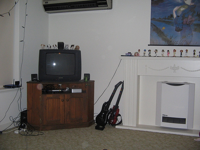

検索結果: 一致度 0.30553093552589417


C:\Users\hiahara\AppData\Local\Temp\ipykernel_18136\1465785085.py:80: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  query_vector = np.array(query_vector, dtype=np.float32)


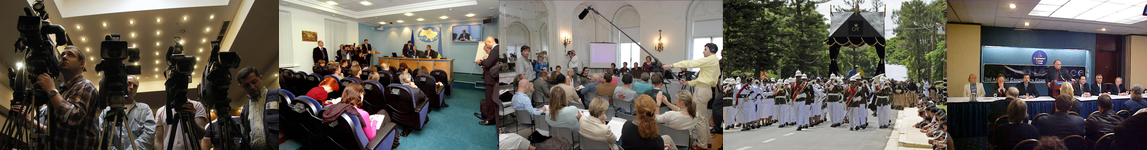

2025-02-09 16:36:11,885 - __main__ - INFO - FAISSインデックスをファイルに保存しました: faiss_index.bin


Rank 1: 距離: 0.30553093552589417, ファイルパス: ..\..\sample_data\WIDER_OpenData\9--Press_Conference\9_Press_Conference_Press_Conference_9_66.jpg
Rank 2: 距離: 0.3050829768180847, ファイルパス: ..\..\sample_data\WIDER_OpenData\9--Press_Conference\9_Press_Conference_Press_Conference_9_35.jpg
Rank 3: 距離: 0.3040508031845093, ファイルパス: ..\..\sample_data\WIDER_OpenData\9--Press_Conference\9_Press_Conference_Press_Conference_9_12.jpg
Rank 4: 距離: 0.28544384241104126, ファイルパス: ..\..\sample_data\WIDER_OpenData\6--Funeral\6_Funeral_Funeral_6_77.jpg
Rank 5: 距離: 0.2772712707519531, ファイルパス: ..\..\sample_data\WIDER_OpenData\9--Press_Conference\9_Press_Conference_Press_Conference_9_60.jpg


In [16]:
import random

# query_image = "../../sample_data/coco_sample_datasets/sample_coco_train2017/000000187979.jpg"   # 検索クエリとなる画像ファイル
query_image = random.choice(list(Path("../../sample_data/coco_sample_datasets/sample_coco_train2017/").glob("*.jpg")))

# 画像検索の実行
search_images(faiss_manager, extractor, query_image, show_result=True)

# インデックスの保存（オプション）
faiss_manager.save("faiss_index.bin")

In [ ]:
# 実行時間の計測
import time

test_num = 100
query_img_paths = [random.choice(list(Path("../../sample_data/coco_sample_datasets/sample_coco_train2017/").glob("**/*.jpg"))) for _ in range(test_num)]

start = time.time()
for img_path in tqdm(query_img_paths):
    search_images(faiss_manager, extractor, query_image, show_result=False)
end = time.time()

print(f"1000回の検索にかかった時間: {end - start:.3f} 秒")
print(f"1回あたりの平均時間: {(end - start) / test_num:.8f} 秒")


  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\hiahara\AppData\Local\Temp\ipykernel_18136\1465785085.py:80: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  query_vector = np.array(query_vector, dtype=np.float32)
100%|██████████| 100/100 [01:45<00:00,  1.05s/it]

1000回の検索にかかった時間: 105.043 秒
1回あたりの平均時間: 0.10504268 秒
